In [49]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used
import numpy as np
import matplotlib.pyplot as plt
import os.path
import torch
import numpy as np # this module is useful to work with numerical arrays
from torchvision import transforms
from torch.utils.data import DataLoader #,random_split
import torch.optim as optim
import torch

from CSIencoder import DMEncoder
encoded_dim  = 2
lr= 0.01
batch_size = 32
weight_decay = 0.0001
num_epochs = 100
skip_train = False

In [50]:
Ns  = np.array([512, 512, 512, 512, 512, 512, 512, 512, 883])
NN  = np.sum(Ns) 
N_trained = int(0.9*NN)
print(N_trained)
N_tested  = NN-N_trained
A=56
M=5

def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     torch.cuda.manual_seed(seed)
     np.random.seed(seed)
setup_seed(2022) 
RandIndexs = torch.randperm(NN).numpy()

XYs  = np.load("XYs.npy")
XYs  = XYs[RandIndexs,::]

CSIs = np.load("CSIs_used.npy")
CSIs = CSIs[RandIndexs,::]

Train_CSIs  = CSIs[0:N_trained,::]

print("XYs  is of shape {}".format(XYs.shape ))
print("CSIs is of shape {}".format(CSIs.shape))


4481
XYs  is of shape (4979, 3)
CSIs is of shape (4979, 56, 56)


In [51]:
torch.manual_seed(0)
encoder = DMEncoder(encoded_space_dim=encoded_dim)
params_to_optimize = [{'params': encoder.parameters()}]
optim  = torch.optim.Adam(params_to_optimize, lr=lr,weight_decay=weight_decay)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')
encoder.to(device)

Selected device: cuda


DMEncoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): Tanh()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Tanh()
    (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Tanh()
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): Tanh()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=20000, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [52]:
train_dataset = torch.Tensor(CSIs[0:N_trained])
valid_dataset = torch.Tensor(CSIs[N_trained: ])

train_dataset = torch.unsqueeze(train_dataset, 1).to(device)
valid_dataset = torch.unsqueeze(valid_dataset, 1).to(device)

train_transform = transforms.Compose([transforms.ToTensor(),])
valid_transform = transforms.Compose([transforms.ToTensor(),])

train_dataset.transform = train_transform
valid_dataset.transform = valid_transform

n_train_samples = len(train_dataset)
n_valid_samples = len(valid_dataset)

In [53]:
diz_loss = {'train_loss':[]}
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=5, gamma=0.5)
XYs_train = torch.tensor(XYs[0:N_trained,0:2]).to(device)

if skip_train  == False:
   for epoch in range(num_epochs):
      train_loader = DataLoader(range(len(train_dataset)), batch_size=batch_size,shuffle=True)
      encoder.train()
      train_loss = []
      for image_Indexs in train_loader:
         image_a = train_dataset[image_Indexs,::]
         label_a = XYs_train[image_Indexs,0:2]
         # Encode data
         image_batch = image_a
         image_batch = image_batch.to(device)
         encoded_a   = encoder(image_batch)
         # Evaluate loss
         loss = 0
         for bi in range(image_Indexs.numel()):
            z_i  = encoded_a[bi,:]
            p_i  = label_a[bi,:]
            mle  = torch.norm(z_i - p_i)
            loss = loss + mle
         loss= loss.to(device)
         optim.zero_grad()
         loss.backward()
         optim.step()
         train_loss.append(loss.detach().cpu().numpy())
      scheduler.step()
      diz_loss['train_loss'].append(np.mean(train_loss))
      print('\n EPOCH {}/{} \t train loss {}'.format(epoch + 1, num_epochs,np.mean(train_loss)))
   torch.save(encoder,"DMCSIencoder.pkl")


 EPOCH 1/100 	 train loss 7579.0206268665725

 EPOCH 2/100 	 train loss 4631.443924882931

 EPOCH 3/100 	 train loss 3186.701741383585

 EPOCH 4/100 	 train loss 2519.8060888798977

 EPOCH 5/100 	 train loss 2291.822459005602

 EPOCH 6/100 	 train loss 2161.201830210908

 EPOCH 7/100 	 train loss 2050.5822243055154

 EPOCH 8/100 	 train loss 1943.7900642022576

 EPOCH 9/100 	 train loss 1912.3380543959024

 EPOCH 10/100 	 train loss 1882.797896922201

 EPOCH 11/100 	 train loss 1819.4697908331914

 EPOCH 12/100 	 train loss 1788.7206173172958

 EPOCH 13/100 	 train loss 1772.8251091685565

 EPOCH 14/100 	 train loss 1730.108657707019

 EPOCH 15/100 	 train loss 1717.5231510202698

 EPOCH 16/100 	 train loss 1665.1941363938265

 EPOCH 17/100 	 train loss 1637.971306630888

 EPOCH 18/100 	 train loss 1604.1491322781308

 EPOCH 19/100 	 train loss 1594.2014118737732

 EPOCH 20/100 	 train loss 1564.4139344783505

 EPOCH 21/100 	 train loss 1547.8165378830643

 EPOCH 22/100 	 train loss 1

In [54]:
encoder = DMEncoder(encoded_space_dim = encoded_dim)
encoder = torch.load("DMCSIencoder.pkl") 
device  = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')
encoder.to(device)

from tqdm.notebook import tqdm
import pandas as pd 
encoded_samples = []
dataset = torch.Tensor(CSIs)
dataset = torch.unsqueeze(dataset, 1)
for sample in tqdm(dataset):
    img = sample.unsqueeze(0).to(device)
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)

Selected device: cuda


  0%|          | 0/4979 [00:00<?, ?it/s]

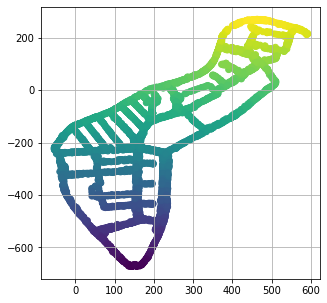

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/4481 [00:00<?, ?it/s]

In [55]:
from sklearn.manifold import TSNE
plt.figure(figsize=(5,5))
plt.scatter(XYs[:,0],XYs[:,1],c=XYs[:,1],cmap = 'viridis')
plt.grid()
plt.show()

encoded_tests = []
for sample in tqdm(valid_dataset):
    img = sample.unsqueeze(0).to(device)
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_tests.append(encoded_sample)
encoded_tests = pd.DataFrame(encoded_tests)

encoded_train = []
for sample in tqdm(train_dataset):
    img = sample.unsqueeze(0).to(device)
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_train.append(encoded_sample)
encoded_train = pd.DataFrame(encoded_train)

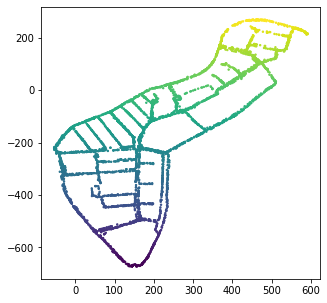

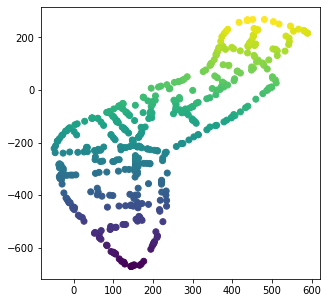

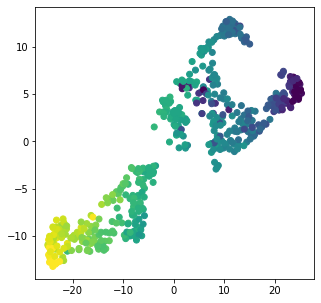

In [56]:
tsne = TSNE(n_components=2,perplexity = 50)
tsne_tests = tsne.fit_transform(encoded_tests)
XYs_train = XYs[0:N_trained,0:2]
XYs_tests = XYs[N_trained:, 0:2]
x = XYs[N_trained:NN,0]
y = XYs[N_trained:NN,1]

plt.figure(figsize=(5,5))
plt.scatter(XYs[:,0],XYs[:,1],c = XYs[:,1],cmap = 'viridis',s=2)
plt.savefig("CTW2020.pdf",  dpi = 400, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(x,y,c = XYs_tests[:,1],cmap = 'viridis')
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(tsne_tests[:,0],tsne_tests[:,1],c=XYs_tests[:,1],cmap = 'viridis')
plt.show()

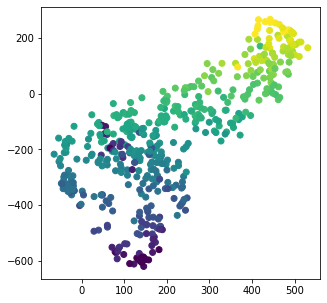

54.84605970124766


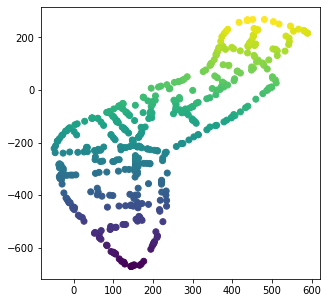

In [64]:
# on the test set
XYs_pred_DM = encoded_tests.to_numpy()
x = XYs_pred_DM[:,0], 
y = XYs_pred_DM[:,1], 

plt.figure(figsize=(5,5))
plt.scatter(x,y,c=XYs_tests[:,1],cmap = 'viridis')
plt.savefig("DM.pdf",  dpi = 400, bbox_inches = 'tight', pad_inches = 0)
plt.show()

Es = XYs_tests - XYs_pred_DM
Es_dis  = np.sqrt(Es[:,0]*Es[:,0] + Es[:,1]*Es[:,1])
MLE_dis = np.mean(Es_dis)
print(MLE_dis)
data_sorted_dis = np.sort(Es_dis)
p_dis = 1. * np.arange(len(Es_dis)) / (len(Es_dis) - 1)

x = XYs[N_trained:NN,0],
y = XYs[N_trained:NN,1], 
plt.figure(figsize=(5,5))
plt.scatter(x,y,c=XYs_tests[:,1],cmap = 'viridis')
#plt.savefig("True.pdf", dpi = 400)
plt.savefig("True.pdf", dpi = 400, bbox_inches = 'tight', pad_inches = 0)
plt.show()

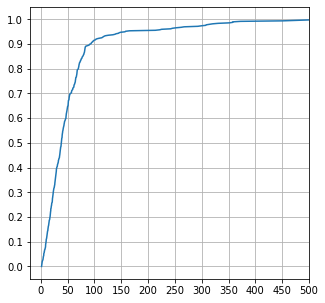

In [58]:
#===================================================================
plt.figure(figsize=(5,5))
plt.grid()
plt.plot(data_sorted_dis,p_dis)
plt.xlim((-20,400))
plt.xticks(np.arange(0,550,50))
plt.yticks(np.arange(0,1.05,0.1))
plt.show()

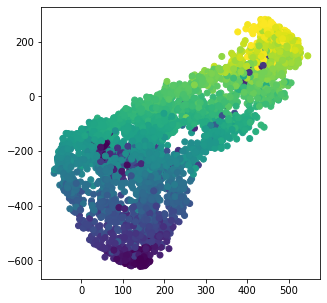

41.09512533722675


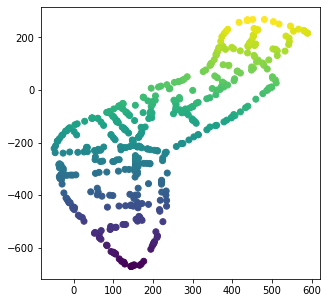

In [59]:
# on the train set
XYs_pred_DM2 = encoded_train.to_numpy()
x = XYs_pred_DM2[:,0], 
y = XYs_pred_DM2[:,1], 

plt.figure(figsize=(5,5))
plt.scatter(x,y,c=XYs_train[:,1],cmap = 'viridis')
plt.show()

Es = XYs_train - XYs_pred_DM2
Es_dis  = np.sqrt(Es[:,0]*Es[:,0] + Es[:,1]*Es[:,1])
MLE_dis = np.mean(Es_dis)
print(MLE_dis)
data_sorted_dis2 = np.sort(Es_dis)
p_dis2 = 1. * np.arange(len(Es_dis)) / (len(Es_dis) - 1)

x = XYs[N_trained:NN,0],
y = XYs[N_trained:NN,1], 
plt.figure(figsize=(5,5))
plt.scatter(x,y,c=XYs_tests[:,1],cmap = 'viridis')
#plt.savefig("True.pdf", dpi = 400)
plt.savefig("True.pdf", dpi = 400, bbox_inches = 'tight', pad_inches = 0)
plt.show()

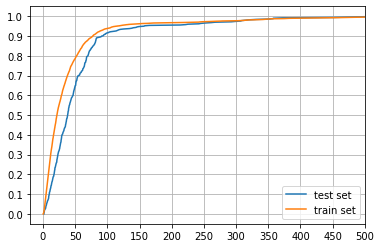

In [63]:
#===================================================================
plt.figure(figsize=(6,4))
plt.grid()
plt.plot(data_sorted_dis,p_dis,label='test set')
plt.plot(data_sorted_dis2,p_dis2,label='train set')
plt.xlim((-20,400))
plt.xticks(np.arange(0,550,50))
plt.yticks(np.arange(0,1.05,0.1))
plt.legend()
plt.show()